In [101]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path
import yaml
import re

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

import vivarium_helpers as vh
import vivarium_helpers.id_helper as idh
from vivarium_helpers.vph_output.operations import VPHOperator

!date
!whoami
!pwd

Wed Oct  8 01:53:09 PDT 2025
ndbs
/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers


# V&V list

# Find data

In [102]:
# Project directory
%cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers


In [103]:
# Results directory containing model 6 results for all locations
!ls -halt results/model6.0/model_spec/2025_10_03_12_33_34/results

total 232M
drwxrwsr-x 5 sbachmei IHME-Simulationscience 4.5K Oct  3 13:06 ..
drwxrwsr-x 2 sbachmei IHME-Simulationscience 4.5K Oct  3 13:06 .
-rw-rw-r-- 1 sbachmei IHME-Simulationscience  16M Oct  3 13:06 baseline_test_counts_among_eligible.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 3.8M Oct  3 13:05 bbbm_test_eligibility_counts.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 101M Oct  3 13:05 ylds.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience  55M Oct  3 13:05 ylls.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 9.1M Oct  3 13:05 deaths.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 6.0M Oct  3 13:05 new_simulants.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience  12M Oct  3 13:05 transition_count_alzheimers_disease_and_other_dementias.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 2.1M Oct  3 13:05 bbbm_test_counts.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience  29M Oct  3 13:04 person_time_alzheimers_disease_and_other_dementias.parquet

In [104]:
!ls results/model6.0/model_spec/2025_10_03_12_33_34/

__pycache__		   keyspace.yaml	     requirements.txt
branches.yaml		   logs			     results
finished_sim_metadata.csv  model_specification.yaml  settings.py


In [ ]:
locations = [
    'United States of America',
    'Brazil',
    'China',
    'Germany',
    'Israel',
    'Japan',
    'Spain',
    'Sweden',
    'Taiwan (Province of China)',
    'United Kingdom',
]

# Define some shorter names to use for plotting
location_to_short_name = ({loc: loc for loc in locations}| {
    'Taiwan (Province of China)': 'Taiwan',
    'United Kingdom': 'UK',
    'United States of America': 'USA',
})

# Select a subset of locations to draw plots for
locations_to_plot = locations[:2]

project_dir = '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/'

model_number = '6.0'
run_subdirectories = [
    f'results/model{model_number}/model_spec/2025_10_03_12_33_34/',
]
run_dirs = [project_dir + run_subdir for run_subdir in run_subdirectories]
results_dirs = [run_dir + 'results/' for run_dir in run_dirs]

# # Option 1: One results directory per location
# location_to_results_dir = {
#     loc: path for loc, path in zip(locations, results_dirs)}

# Option 2: All locations in one results directory
location_to_results_dir = {'all': results_dirs[0]}

location_to_artifact_subdir = {loc: loc.lower().replace(' ', '_') for loc in locations}
artifact_subpaths = [f'artifacts/model{model_number}/' + subdir + '.hdf' for subdir in location_to_artifact_subdir.values()]
location_to_artifact_path = {loc: project_dir + subpath for loc, subpath in zip(locations, artifact_subpaths)}
artifact_path_to_location = {path: loc for loc, path in location_to_artifact_path.items()}
# artifact_path_to_location = {project_dir + subpath: loc for subpath, loc in zip(artifact_subpaths, locations)}
artifact_path_to_location

{'/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/united_states_of_america.hdf': 'United States of America',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/brazil.hdf': 'Brazil',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/china.hdf': 'China',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/germany.hdf': 'Germany',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/israel.hdf': 'Israel',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/japan.hdf': 'Japan',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/spain.hdf': 'Spain',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/sweden.hdf': 'Sweden',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/taiwan_(province_of

# Get list of draws and draw columns from `keyspace.yaml`, and reduce to a subset of draws to save memory and time

In [106]:
with open(run_dirs[0] + 'keyspace.yaml', 'r') as keyspace_file:
    keyspace = yaml.safe_load(keyspace_file)
draws = keyspace['input_draw']
print(draws)

[457, 169, 323, 392, 346, 480, 258, 446, 356, 273, 158, 24, 265, 317, 177, 199, 2, 13, 46, 89, 41, 113, 262, 460, 499]


In [ ]:
# I ended up never actually using this -- I just used all the draws
draws = sorted(draws[:10]) # reduce to a subset of draws to save memory, and sort
draw_cols = [f'draw_{i}' for i in draws]
print(draw_cols)

['draw_169', 'draw_258', 'draw_273', 'draw_323', 'draw_346', 'draw_356', 'draw_392', 'draw_446', 'draw_457', 'draw_480']


# Load one artifact and define age bins

In [108]:
usa_artifact_path = location_to_artifact_path['United States of America']
usa_art = Artifact(usa_artifact_path)
print(usa_art.load('metadata.locations'))
print(usa_art)

['United States of America']
Artifact containing the following keys:
metadata
	keyspace
	locations
population
	location
	structure
	age_bins
	demographic_dimensions
	theoretical_minimum_risk_life_expectancy
	scaling_factor
cause
	all_causes
		cause_specific_mortality_rate
	alzheimers
		prevalence
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		mci_to_dementia_transition_rate
		susceptible_to_bbbm_transition_count
		population_incidence_rate
		mci_disability_weight
	alzheimers_disease_and_other_dementias
		cause_specific_mortality_rate
		excess_mortality_rate
		disability_weight
		restrictions
covariate
	live_births_by_sex
		estimate
testing_rates
	csf
	pet



In [109]:
# age_bins is an empty DataFrame with a MultiIndex storing age group data
age_bins = usa_art.load('population.age_bins')
age_dictionary = (
    age_bins
    .reset_index()
    .assign(age_group=lambda df: df['age_group_name'].str.replace(' ', '_'))
    # Filter to ages that actually appear in our sim
    .query("age_start >= 25")
)
age_dictionary

,age_group_id,age_group_name,age_start,age_end,age_group
4,10,25 to 29,25.0,30.0,25_to_29
5,11,30 to 34,30.0,35.0,30_to_34
6,12,35 to 39,35.0,40.0,35_to_39
7,13,40 to 44,40.0,45.0,40_to_44
8,14,45 to 49,45.0,50.0,45_to_49
9,15,50 to 54,50.0,55.0,50_to_54
10,16,55 to 59,55.0,60.0,55_to_59
11,17,60 to 64,60.0,65.0,60_to_64
12,18,65 to 69,65.0,70.0,65_to_69
13,19,70 to 74,70.0,75.0,70_to_74


In [110]:
age_bins.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 19 entries, (6, '5 to 9', 5.0, 10.0) to (235, '95 plus', 95.0, 125.0)
Empty DataFrame


# Define functions to load and merge Artifact data from all locations, and to summarize Artifact data for plotting

In [111]:
def load_artifact_data(
    key,
    filter_terms=None,
    location_to_artifact_path=location_to_artifact_path,
):
    dfs = {} # dict to map locations to artifact data
    for location, path in location_to_artifact_path.items():
        art = Artifact(path, filter_terms)
        # Check to make sure location matches artifact
        art_locations = art.load('metadata.locations')
        assert len(art_locations) == 1 and art_locations[0] == location, \
            f'Unexpected locations in artifact: {location=}, {art_locations=}'
        df = art.load(key)
        dfs[location] = df
    data = pd.concat(dfs, names=['location', *df.index.names])
    return data

def lower(x):
    return x.quantile(0.025)

def upper(x):
    return x.quantile(0.975)

def summarize_artifact_data(df):
    summary = df.agg(['mean', lower, upper], axis='columns')
    return summary

# Load CSF and PET testing rates

In [112]:
# NOTE: Dropping level 1 of index because it is meaningless, containing
# all 0s: 
# https://github.com/ihmeuw/vivarium_csu_alzheimers/blob/7674a25da52e8b9ee23c0184a2e65c6f53aac335/src/vivarium_csu_alzheimers/data/loader.py#L487-L489
csf_rates = load_artifact_data('testing_rates.csf').droplevel(1)
pet_rates = load_artifact_data('testing_rates.pet').droplevel(1)
existing_test_rates = (
    pd.concat(
        {'csf': csf_rates, 'pet': pet_rates}, names=['test_type', 'location'])
    .rename_axis(columns='input_draw')
)
existing_test_rates

input_draw                              draw_0    draw_1    draw_2    draw_3  \
test_type location                                                             
csf       United States of America    0.086170  0.140511  0.102449  0.092320   
          Brazil                      0.105865  0.173411  0.126100  0.113509   
          China                       0.035023  0.057369  0.041717  0.037552   
          Germany                     0.148848  0.243818  0.177298  0.159596   
          Israel                      0.105865  0.173411  0.126100  0.113509   
          Japan                       0.105865  0.173411  0.126100  0.113509   
          Spain                       0.195811  0.320745  0.233237  0.209950   
          Sweden                      0.322372  0.528056  0.383988  0.345649   
          Taiwan (Province of China)  0.105865  0.173411  0.126100  0.113509   
          United Kingdom              0.075618  0.123865  0.090071  0.081078   
pet       United States of America    0.172089  0.196148  0.165458  0.088834   
          Brazil                      0.170942  0.194840  0.164355  0.088241   
          China                       0.069983  0.079767  0.067286  0.036126   
          Germany                     0.183562  0.209225  0.176489  0.094756   
          Israel                      0.170942  0.194840  0.164355  0.088241   
          Japan                       0.170942  0.194840  0.164355  0.088241   
          Spain                       0.297141  0.338682  0.285691  0.153386   
          Sweden                      0.051627  0.058844  0.049637  0.026650   
          Taiwan (Province of China)  0.170942  0.194840  0.164355  0.088241   
          United Kingdom              0.122757  0.139919  0.118027  0.063368   

input_draw                              draw_4    draw_5    draw_6    draw_7  \
test_type location                                                             
csf       United States of America    0.126445  0.062653  0.118921  0.087192   
          Brazil                      0.155928  0.076634  0.146575  0.107136   
          China                       0.051585  0.025353  0.048491  0.035443   
          Germany                     0.219236  0.107748  0.206087  0.150634   
          Israel                      0.155928  0.076634  0.146575  0.107136   
          Japan                       0.155928  0.076634  0.146575  0.107136   
          Spain                       0.288407  0.141744  0.271109  0.198161   
          Sweden                      0.474817  0.233359  0.446338  0.326240   
          Taiwan (Province of China)  0.155928  0.076634  0.146575  0.107136   
          United Kingdom              0.111377  0.054738  0.104697  0.076526   
pet       United States of America    0.164784  0.180419  0.178008  0.223862   
          Brazil                      0.163686  0.179216  0.176821  0.222370   
          China                       0.067012  0.073370  0.072390  0.091037   
          Germany                     0.175770  0.192447  0.189875  0.238786   
          Israel                      0.163686  0.179216  0.176821  0.222370   
          Japan                       0.163686  0.179216  0.176821  0.222370   
          Spain                       0.284528  0.311524  0.307361  0.386535   
          Sweden                      0.049435  0.054126  0.053402  0.067159   
          Taiwan (Province of China)  0.163686  0.179216  0.176821  0.222370   
          United Kingdom              0.117546  0.128699  0.126979  0.159688   

input_draw                              draw_8    draw_9  ...  draw_490  \
test_type location                                        ...             
csf       United States of America    0.096971  0.095522  ...  0.131668   
          Brazil                      0.119291  0.117490  ...  0.162419   
          China                       0.039465  0.038869  ...  0.053733   
          Germany                     0.167726  0.165193  ...  0.228364   
          Israel            

In [113]:
existing_test_rates.stack().rename('value').to_frame()

value
test_type location                 input_draw          
csf       United States of America draw_0      0.086170
                                   draw_1      0.140511
                                   draw_2      0.102449
                                   draw_3      0.092320
                                   draw_4      0.126445
...                                                 ...
pet       United Kingdom           draw_495    0.143989
                                   draw_496    0.129093
                                   draw_497    0.117380
                                   draw_498    0.107381
                                   draw_499    0.068556

[10000 rows x 1 columns]

# Create VPHOperator object to perform operations on simulation output

In [114]:
ops = VPHOperator()
ops.index_cols.append('location')
ops.index_cols

['input_draw', 'scenario', 'location']

In [ ]:
# Oh good, the VPHOperator object must have made its own copy of the index
# columns in the module, even though the code doesn't explicitly specify
# this -- I was worried that 'location' would have gotten added to the
# module's INDEX_COLUMNS constant
vh.vph_output.operations.INDEX_COLUMNS

['input_draw', 'scenario']

# Define a filter

In [116]:
# draw_filter = ('input_draw', in, draws)

# Define function to load simulation output, and load baseline test counts

In [ ]:
def load_sim_output(
        measure,
        results_dict=location_to_results_dir,
        artifact_path_to_location=artifact_path_to_location,
        drop_superfluous_cols=True, # drop redundant or empty columns
        force_categorical=True,
        aggregate_seeds=True,
        raw=False, # Overrides other parameters if True
        **kwargs, # keyword args to pass to .read_parquet
    ):
    """Load simulation output from .parquet files for all locations,
    optionally reducing the size of the data when possible. Returns
    concatenated outputs with a 'location' column added.
    """
    if raw:
        drop_superfluous_cols = False
        force_categorical = False
        aggregate_seeds = False

    dfs = []
    for location, directory in results_dict.items():
        df = pd.read_parquet(Path(directory) / f'{measure}.parquet', **kwargs)
        if drop_superfluous_cols:
            # Drop redundant columns
            for col1, col2 in [
                ('input_draw', 'input_draw_number'),
                ('entity', 'sub_entity'),
            ]:
                if (col1 in df and col2 in df and df[col1].equals(df[col2])):
                    df.drop(columns=col2, inplace=True)
            # Drop empty columns
            for col in df:
                if df[col].isna().all():
                    df.drop(columns=col, inplace=True)
        if force_categorical:
            convert_to_categorical(df, inplace=True)
        if aggregate_seeds:
            # Use default index and value columns when aggregating
            df = vh.vph_output.operations.marginalize(df, 'random_seed')
        if location == 'all':
            if 'artifact_path' in df:
                df['location'] = df['artifact_path'].map(artifact_path_to_location)
        else:
            df['location'] = location
        dfs.append(df)
    df = pd.concat(dfs)
    return df

# TODO: Consider making certain columns ordered Categoricals
def convert_to_categorical(df, inplace=False):
    """Convert all columns except float columns to categorical. This
    saves lots of memory, allowing us to load and manipulate larger
    DataFrames.
    """
    if not inplace:
        df = df.copy()
    for col in df:
        if df[col].dtype not in ('float', 'category'):
            df[col] = df[col].astype('category')
    if not inplace:
        return df
    else:
        return None

# NOTE: Differs from version in Vivarium Helpers in that here,
# dropna=False
def marginalize(
    df:pd.DataFrame,
    marginalized_cols,
    value_cols=None,
    reset_index=True,
    func='sum',
    args=(), # Positional args to pass to func in DataFrameGroupBy.agg
    **kwargs, # Keywords to pass to DataFrameGroupBy.agg
)->pd.DataFrame:
    if value_cols is None:
        value_cols = vh.vph_output.operations.value_col
    marginalized_cols = vh.utils._ensure_iterable(marginalized_cols)
    value_cols = vh.utils._ensure_iterable(value_cols)
    # Move Index levels into columns to enable passing index
    # level names as well as column names to marginalize
    df = vh.utils._ensure_columns_not_levels(df, marginalized_cols)
    groupby_cols = df.columns.difference(
        # must convert Index to list for groupby to work properly
        [*marginalized_cols, *value_cols]).to_list()
    aggregated_data = df.groupby(
        # observed=True needed for Categorical data
        groupby_cols, as_index=(not reset_index),
        observed=True, dropna=False,
    )[value_cols].agg(func, *args, **kwargs)
    return aggregated_data

def summarize_sim_data(df, age_dictionary=age_dictionary):
    """Summarize simulation data for plotting."""
    # Merge to get an age_start column for plotting
    if 'age_group' in df:
        df = df.merge(age_dictionary, on='age_group')
    # Summarize, and rename percentiles to match artifact
    summary = ops.describe(df).rename(
        columns={'2.5%': 'lower', '97.5%': 'upper'})
    return summary


In [118]:


# On the first attempt, this resulted in an empty DataFrame. Using
# raw=True, I determined that the .groupby was failing because of NaNs
# in the sub_entity column, since dropna=True by default.
existing_tests = load_sim_output(
    'baseline_test_counts_among_eligible',
    # raw=True,
    )
existing_tests

,age_group,artifact_path,entity,entity_type,event_year,input_draw,measure,scenario,sex,testing_state,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2025,356,baseline_test_counts_among_eligible,baseline,Female,not_tested,0.0,Japan
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2025,356,baseline_test_counts_among_eligible,baseline,Female,csf,0.0,Japan
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2025,356,baseline_test_counts_among_eligible,baseline,Female,pet,0.0,Japan
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2025,356,baseline_test_counts_among_eligible,baseline,Female,bbbm,0.0,Japan
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2025,356,baseline_test_counts_among_eligible,baseline,Male,not_tested,0.0,Japan
...,...,...,...,...,...,...,...,...,...,...,...,...
4559995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2100,265,baseline_test_counts_among_eligible,bbbm_testing,Female,bbbm,5.0,China
4559996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2100,265,baseline_test_counts_among_eligible,bbbm_testing,Male,not_tested,24.0,China
4559997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2100,265,baseline_test_counts_among_eligible,bbbm_testing,Male,csf,1.0,China
4559998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2100,265,baseline_test_counts_among_eligible,bbbm_testing,Male,pet,2.0,China


In [119]:
# Check memory usage -- loading it raw, it took up 2.1 GB
existing_tests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4560000 entries, 0 to 4559999
Data columns (total 12 columns):
 #   Column         Dtype   
---  ------         -----   
 0   age_group      category
 1   artifact_path  category
 2   entity         category
 3   entity_type    category
 4   event_year     category
 5   input_draw     category
 6   measure        category
 7   scenario       category
 8   sex            category
 9   testing_state  category
 10  value          float64 
 11  location       category
dtypes: category(11), float64(1)
memory usage: 82.6 MB


In [120]:
# See if there is only one measure, or more
existing_tests.measure.unique()

['baseline_test_counts_among_eligible']
Categories (1, object): ['baseline_test_counts_among_eligible']

In [121]:
# Check whether all values are integers -- yes
(existing_tests.value % 1).unique()

array([0.])

# Divide to calculate CSF/PET testing rates from sim

In [122]:
sim_test_rates = ops.ratio(
    existing_tests,
    existing_tests,
    strata = ['event_year'],
    numerator_broadcast='testing_state',
)
sim_test_rates

,event_year,input_draw,scenario,location,testing_state,value,numerator_measure,denominator_measure,multiplier
0,2025,2,baseline,Brazil,not_tested,0.695850,baseline_test_counts_among_eligible,baseline_test_counts_among_eligible,1
1,2025,2,baseline,Brazil,csf,0.141521,baseline_test_counts_among_eligible,baseline_test_counts_among_eligible,1
2,2025,2,baseline,Brazil,pet,0.162629,baseline_test_counts_among_eligible,baseline_test_counts_among_eligible,1
3,2025,2,baseline,Brazil,bbbm,0.000000,baseline_test_counts_among_eligible,baseline_test_counts_among_eligible,1
4,2025,2,baseline,China,not_tested,0.895895,baseline_test_counts_among_eligible,baseline_test_counts_among_eligible,1
...,...,...,...,...,...,...,...,...,...
151995,2100,499,bbbm_testing,United Kingdom,bbbm,0.026460,baseline_test_counts_among_eligible,baseline_test_counts_among_eligible,1
151996,2100,499,bbbm_testing,United States of America,not_tested,0.880473,baseline_test_counts_among_eligible,baseline_test_counts_among_eligible,1
151997,2100,499,bbbm_testing,United States of America,csf,0.043145,baseline_test_counts_among_eligible,baseline_test_counts_among_eligible,1
151998,2100,499,bbbm_testing,United States of America,pet,0.053052,baseline_test_counts_among_eligible,baseline_test_counts_among_eligible,1


# Plot test CSF/PET test rates

Let's make a grid of plots with one column for each scenario and one row
for each country. In each axes, plot testing rate over time, with one
line for each of the four testing states, and plot Artifact testing
rates in same color but different line style.

In [123]:
def plot_over_time_by_column(df, colname, ylabel='', title='', uncertainty=True, ax=None):
    """Plot mean value vs. year for each value in the column `colname`,
    optionally with (lower, upper) uncertainty band.
    """
    if ax is None:
        ax = plt.gca()
#     df = cs.age_to_ordered_categorical(df) # Order the age groups chronologically
    # df = csr.to_ordered_categoricals(df)
    
    # agg = df.groupby([colname, 'event_year'])['value'].describe(percentiles=[.025, .975])
    # agg = vh.vph_output.operations.stratify(df, [colname, 'event_year'], func=['mean', lower, upper])['value']
    agg = df.groupby([colname, 'event_year'], observed=True)['value'].agg(['mean', lower, upper])
    col_vals = agg.index.unique(colname)
    for col_val in col_vals:
        values = agg.xs(col_val)
        years = values.index
        ax.plot(years, values['mean'], label=f"{colname}={col_val}")
        if uncertainty:
            # ax.fill_between(years, values['2.5%'], values['97.5%'], alpha=.1)
            ax.fill_between(years, values['lower'], values['upper'], alpha=.1)

    ax.set_xlabel('year')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    return ax

def plot_over_time_by_column_for_row_x_1(
        df, colname, row_variable, ylabel='', suptitle='', uncertainty=True,
        axes_width=12, axes_height=6,
    ):
    """Draw a nx1 figure with rows indexed by location, calling plot_over_time_by_column()
    for each subplot.
    """
    # Get ordered list of locations in the dataframe
    # df = csr.to_ordered_categoricals(df)
    df = convert_to_categorical(df)
    row_values = df[row_variable].unique().sort_values()
    fig, axs = plt.subplots(
        len(row_values), 1,
        figsize=(axes_width, axes_height * len(row_values)))
    for row_num, row_value in enumerate(row_values):
        plot_over_time_by_column(
            df.query(f"{row_variable}==@row_value"),
            colname,
            ylabel,
            f"{row_variable}={row_value}",
            uncertainty,
            ax=axs[row_num],
        )
    fig.suptitle(suptitle, fontsize=18)
    fig.tight_layout()
    return fig

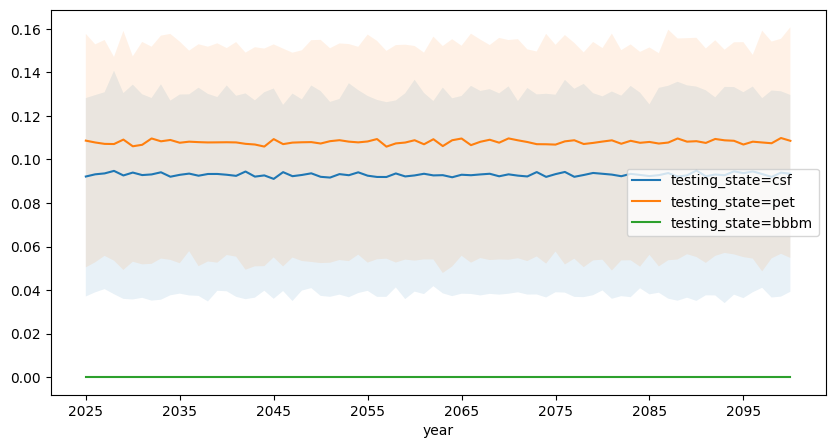

In [124]:
fig, ax = plt.subplots(figsize=(10,5))
plot_over_time_by_column(
    sim_test_rates
    .query("location == 'United Kingdom' and scenario == 'baseline' and testing_state != 'not_tested'"),
    'testing_state')
ax.set_xticks(ax.get_xticks()[::10])
# ax.tick_params(rotation=90)
plt.show()

# Plot existing test rates in baseline for each country

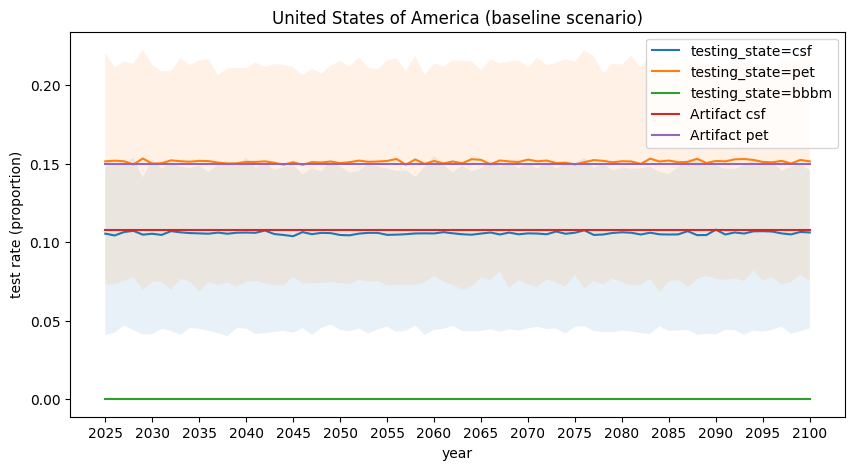

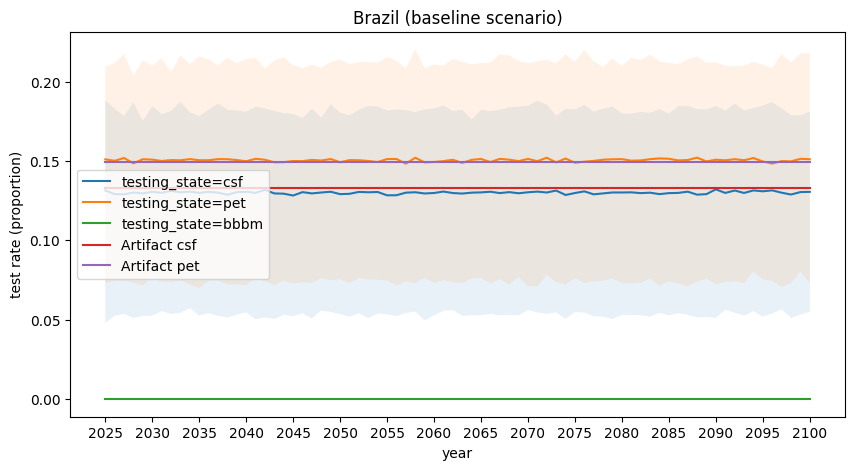

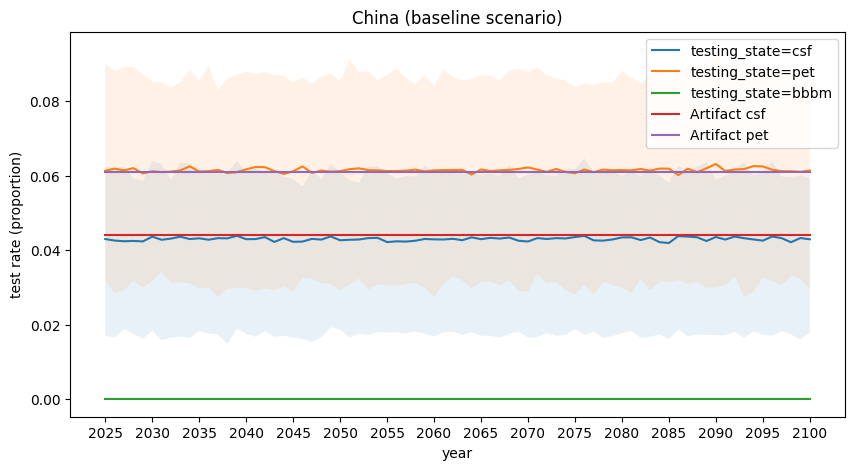

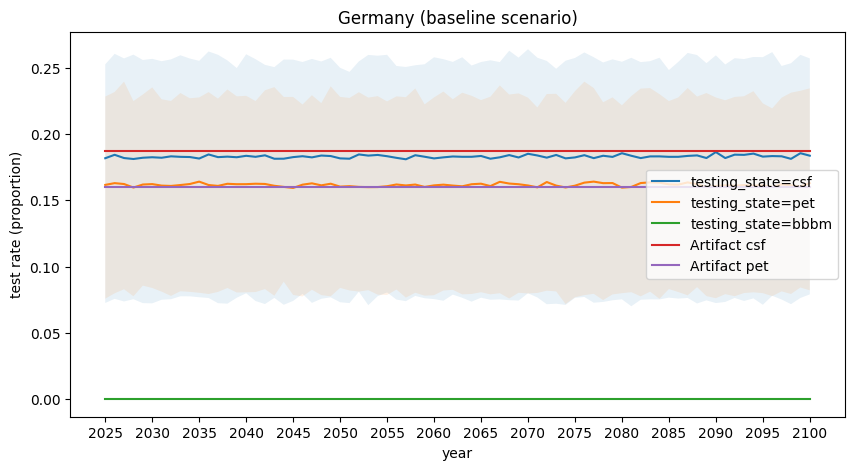

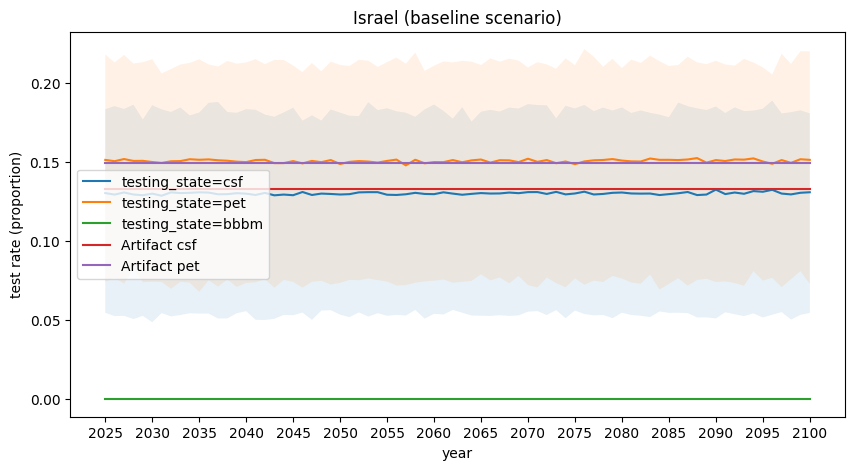

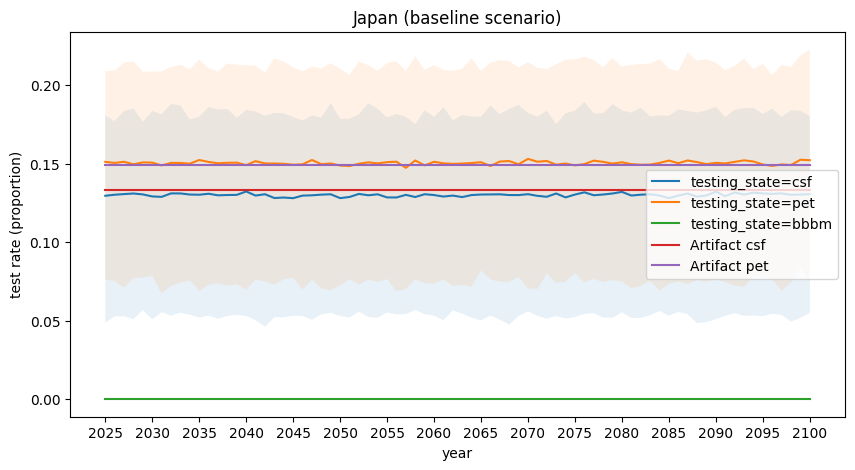

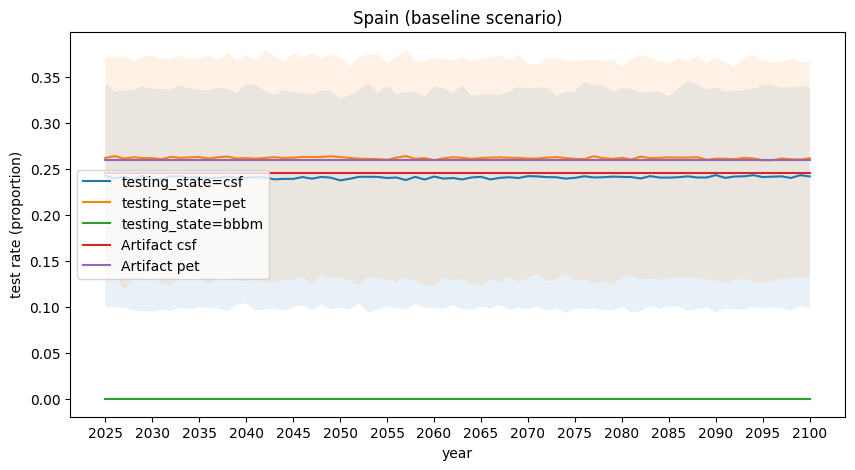

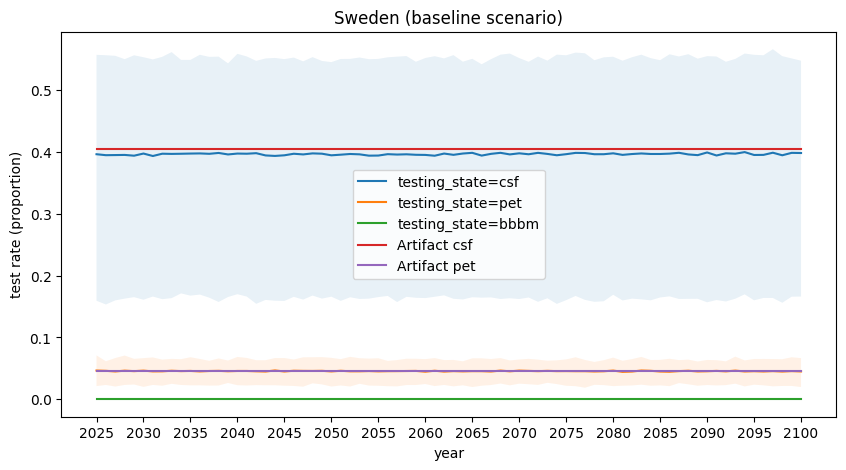

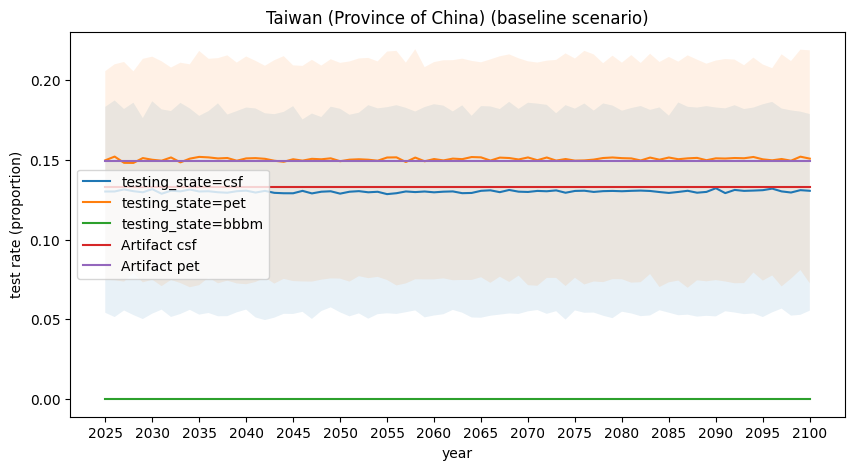

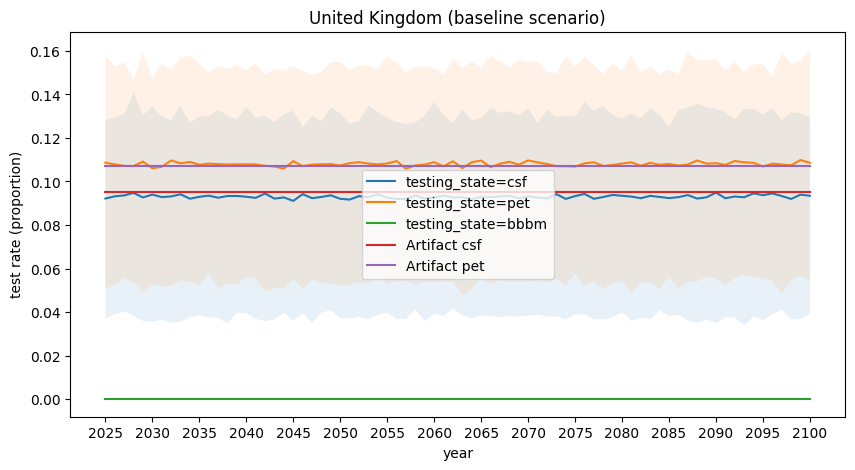

In [125]:
for location in locations:
    fig, ax = plt.subplots(figsize=(10,5))
    plot_over_time_by_column(
        sim_test_rates
        .query("location == @location and scenario == 'baseline' and testing_state != 'not_tested'"),
        'testing_state',
        ylabel='test rate (proportion)',
        title=location + ' (baseline scenario)',
    )
    filtered_x_ticks = ax.get_xticks()[::5]
    ax.set_xticks(filtered_x_ticks)

    artifact_testing_data = summarize_artifact_data(existing_test_rates).query("location==@location")
    for test_type in artifact_testing_data.index.unique('test_type'):
        ax.plot(
            filtered_x_ticks,
            np.broadcast_to(artifact_testing_data.loc[test_type, 'mean'], (len(filtered_x_ticks),),),
            label=f'Artifact {test_type}'
        )
    # ax.tick_params(rotation=90)
    # ax.semilogy()
    # ax.set_ylim(0, 0.1)
    ax.legend()
    plt.show()

# Plot existing tests in baseline and BBBM testing scenarios for one country

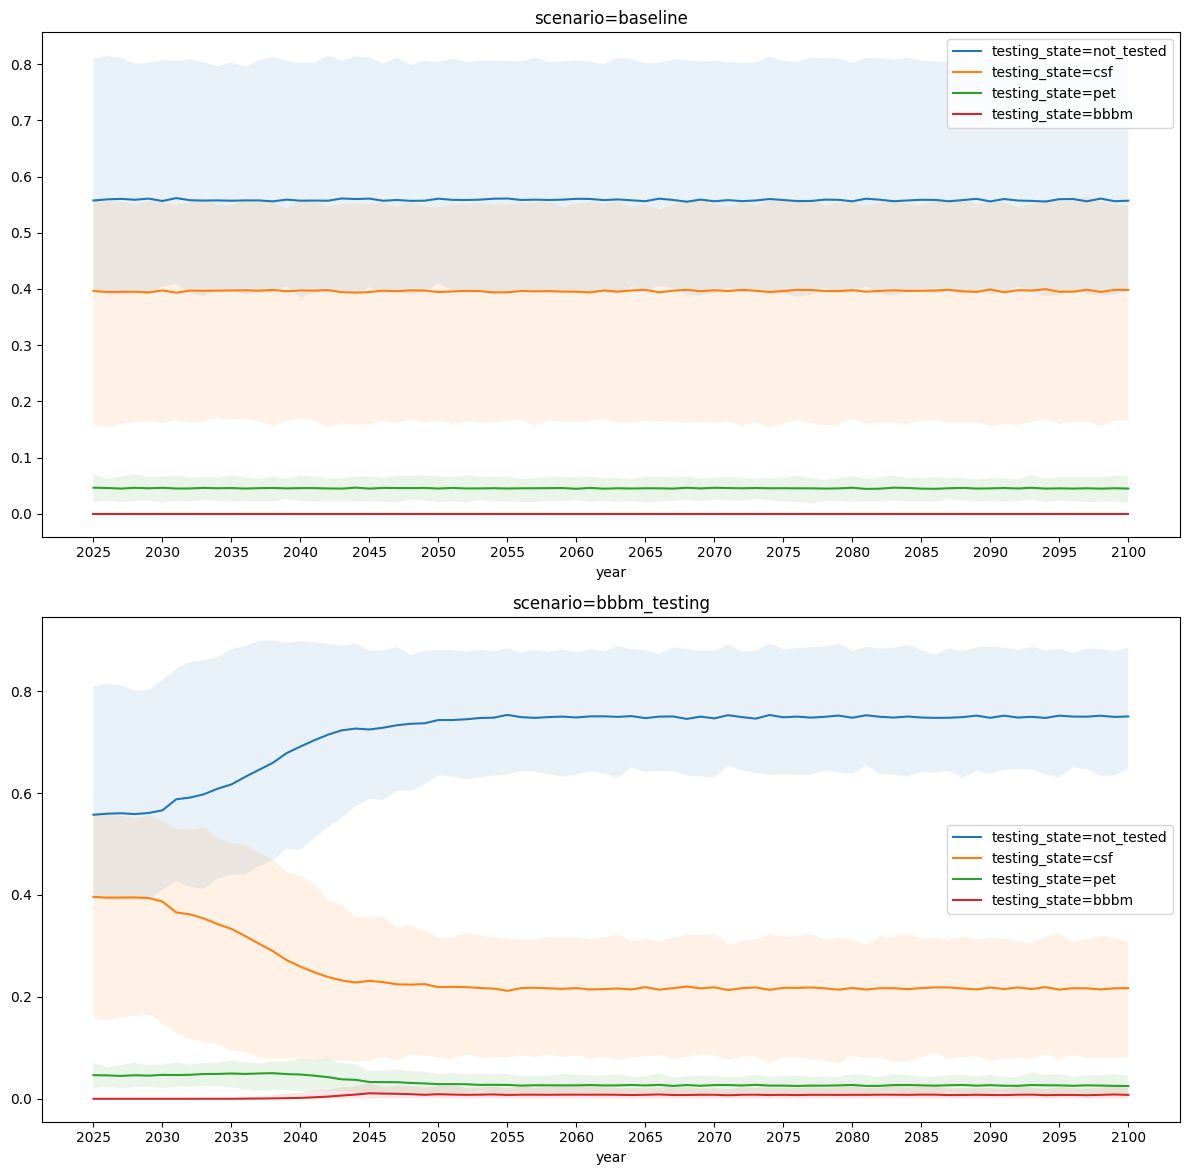

In [126]:
fig = plot_over_time_by_column_for_row_x_1(
    sim_test_rates.query("location == 'Sweden'"),
    'testing_state',
    'scenario',
)
for ax in fig.axes:
    ax.set_xticks(ax.get_xticks()[::5])
plt.show()

# Plot existing test rates in BBBM testing scenario for all countries

Note that CSF testing always decreases before PET testing. This is due
to the way we are using the testing propensity and is undesirable
behavior that we should fix. The desired behavior is for CSF and PET
testing to decrease at the same time.

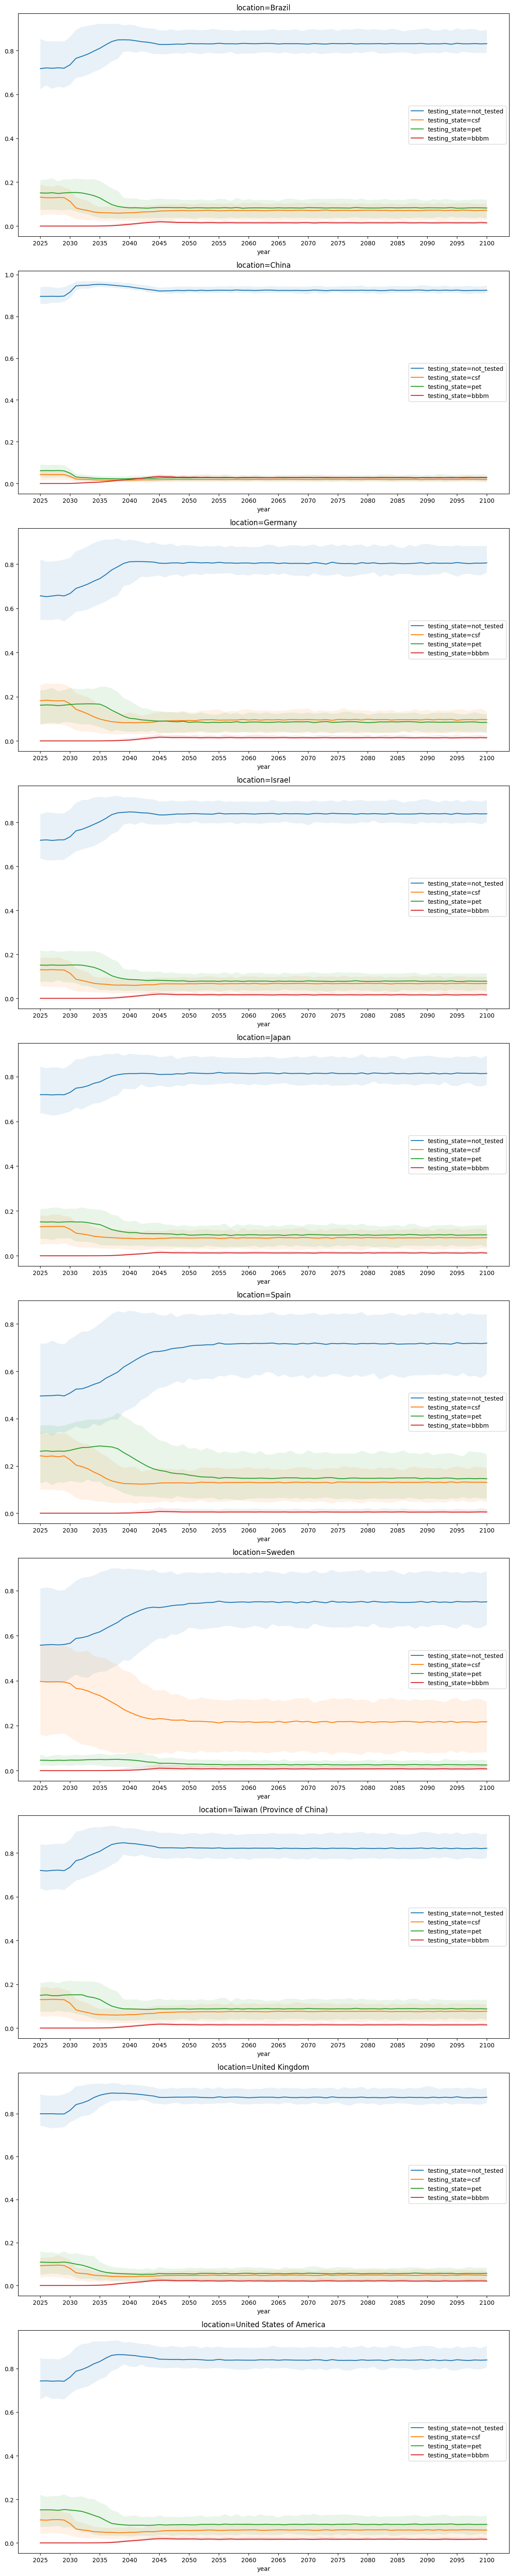

In [127]:
fig = plot_over_time_by_column_for_row_x_1(
    sim_test_rates.query("scenario == 'bbbm_testing'"),
    'testing_state',
    'location',
)
for ax in fig.axes:
    ax.set_xticks(ax.get_xticks()[::5])
plt.show()

# Transform CSF/PET testing rate data

Copy existing test rate data from concept model to compare to artifact.

In [128]:
test_rates_string = """
Location

CSF mean % (Confidence)

PET mean % (Confidence)

United States of America

10.8 (5.4, 16.1)

15.0 (7.5, 22.5)

Germany

18.7 (9.4, 28.1)

16.0 (8.0, 24.0)

Spain

24.6 (12.3, 36.9)

25.9 (12.9, 38.8)

Sweden

40.5 (20.3, 60.8)

4.5 (2.3, 6.8)

United Kingdom

9.5 (4.7, 14.2)

10.7 (5.3, 16)

Japan

13.3 (6.7, 20)

14.9 (7.5, 22.4)

Israel

13.3 (6.7, 20)

14.9 (7.5, 22.4)

Taiwan (Province of China)

13.3 (6.7, 20)

14.9 (7.5, 22.4)

Brazil

13.3 (6.7, 20)

14.9 (7.5, 22.4)

China

4.4 (2.2, 6.6)

6.1 (3, 9.1)
"""
tokens = test_rates_string.split("\n\n")

# Iterate through the tokens, placing locations, CSF rates, and PET
# rates in separate lists to put into DataFrame columns

test_rate_locations = []
csf_rates = []
pet_rates = []

i = iter(tokens)
token = next(i, None)

while token is not None:
    if token in locations:
        test_rate_locations.append(token)
        csf_rates.append(next(i))
        pet_rates.append(next(i))
    token = next(i, None)

raw_test_rates = pd.DataFrame(
    {
        'location': test_rate_locations,
        'csf': csf_rates,
        'pet': pet_rates,
    }
).set_index('location')
raw_test_rates

,csf,pet
location,,
United States of America,"10.8 (5.4, 16.1)","15.0 (7.5, 22.5)"
Germany,"18.7 (9.4, 28.1)","16.0 (8.0, 24.0)"
Spain,"24.6 (12.3, 36.9)","25.9 (12.9, 38.8)"
Sweden,"40.5 (20.3, 60.8)","4.5 (2.3, 6.8)"
United Kingdom,"9.5 (4.7, 14.2)","10.7 (5.3, 16)"
Japan,"13.3 (6.7, 20)","14.9 (7.5, 22.4)"
Israel,"13.3 (6.7, 20)","14.9 (7.5, 22.4)"
Taiwan (Province of China),"13.3 (6.7, 20)","14.9 (7.5, 22.4)"
Brazil,"13.3 (6.7, 20)","14.9 (7.5, 22.4)"


In [129]:
def extract_mean_lower_upper(col: pd.Series) -> pd.DataFrame:
    """Process a pandas Series of strings like '13.3 (6.7, 20)' to
       extract the three numbers mean (lower, upper).
    """
    result = (
        col
        # remove parentheses and commas
        .str.replace(r'[\(\),]', '', regex=True)
        # use regex to extract mean, lower, and upper values from string
        .str.extract(r'(?P<mean>\d+\.*\d*) (?P<lower>\d+\.*\d*) (?P<upper>\d+\.*\d*)')
        .astype('float')
    )
    return result

# Extract the mean, lower, upper values into separate columns
test_rates = pd.concat(
    {test_type: extract_mean_lower_upper(raw_test_rates[test_type])
     for test_type in ['csf', 'pet']
     }, axis=1, names=['test_type', 'estimate'])
test_rates

test_type                    csf               pet            
estimate                    mean lower upper  mean lower upper
location                                                      
United States of America    10.8   5.4  16.1  15.0   7.5  22.5
Germany                     18.7   9.4  28.1  16.0   8.0  24.0
Spain                       24.6  12.3  36.9  25.9  12.9  38.8
Sweden                      40.5  20.3  60.8   4.5   2.3   6.8
United Kingdom               9.5   4.7  14.2  10.7   5.3  16.0
Japan                       13.3   6.7  20.0  14.9   7.5  22.4
Israel                      13.3   6.7  20.0  14.9   7.5  22.4
Taiwan (Province of China)  13.3   6.7  20.0  14.9   7.5  22.4
Brazil                      13.3   6.7  20.0  14.9   7.5  22.4
China                        4.4   2.2   6.6   6.1   3.0   9.1

# Compare existing test rate data between artifact and concept model

In [130]:
artifact_test_rates_summary = (
    summarize_artifact_data(existing_test_rates)
    .rename_axis(columns='estimate')
    .unstack('test_type')
    # Re-order index and columns to match concept model data:
    .reindex(test_rates.index)
    .reorder_levels(['test_type', 'estimate'], axis=1)
    [['csf', 'pet']]
) * 100 # Convert to percent
artifact_test_rates_summary

test_type                         csf                              pet  \
estimate                         mean      lower      upper       mean   
location                                                                 
United States of America    10.800584   5.632618  16.348720  15.008178   
Germany                     18.701020   9.669154  28.397296  16.008723   
Spain                       24.601342  12.719850  37.356871  25.914121   
Sweden                      40.502209  20.941216  61.502165   4.502453   
United Kingdom               9.500518   4.912137  14.426434  10.705834   
Japan                       13.300726   6.876992  20.197007  14.908123   
Israel                      13.300726   6.876992  20.197007  14.908123   
Taiwan (Province of China)  13.300726   6.876992  20.197007  14.908123   
Brazil                      13.300726   6.876992  20.197007  14.908123   
China                        4.400240   2.275095   6.681717   6.103326   

test_type                                         
estimate                        lower      upper  
location                                          
United States of America     7.191193  22.553743  
Germany                      7.670606  24.057326  
Spain                       12.416793  38.942796  
Sweden                       2.157358   6.766123  
United Kingdom               5.129718  16.088337  
Japan                        7.143252  22.403385  
Israel                       7.143252  22.403385  
Taiwan (Province of China)   7.143252  22.403385  
Brazil                       7.143252  22.403385  
China                        2.924418   9.171855

In [131]:
# Check that differences between artifact and concept model are small
np.abs(test_rates - artifact_test_rates_summary).max()

test_type  estimate
csf        mean        0.002209
           lower       0.641216
           upper       0.702165
pet        mean        0.014121
           lower       0.483207
           upper       0.142796
dtype: float64

In [132]:
# It looks like we have exactly the same draws for different countries
existing_test_rates.query("location in ['Brazil', 'Israel']")

input_draw            draw_0    draw_1    draw_2    draw_3    draw_4  \
test_type location                                                     
csf       Brazil    0.105865  0.173411  0.126100  0.113509  0.155928   
          Israel    0.105865  0.173411  0.126100  0.113509  0.155928   
pet       Brazil    0.170942  0.194840  0.164355  0.088241  0.163686   
          Israel    0.170942  0.194840  0.164355  0.088241  0.163686   

input_draw            draw_5    draw_6    draw_7    draw_8    draw_9  ...  \
test_type location                                                    ...   
csf       Brazil    0.076634  0.146575  0.107136  0.119291  0.117490  ...   
          Israel    0.076634  0.146575  0.107136  0.119291  0.117490  ...   
pet       Brazil    0.179216  0.176821  0.222370  0.119989  0.153561  ...   
          Israel    0.179216  0.176821  0.222370  0.119989  0.153561  ...   

input_draw          draw_490  draw_491  draw_492  draw_493  draw_494  \
test_type location                                                     
csf       Brazil    0.162419  0.169817  0.145370  0.109777  0.132227   
          Israel    0.162419  0.169817  0.145370  0.109777  0.132227   
pet       Brazil    0.159888  0.235068  0.165442  0.112769  0.100389   
          Israel    0.159888  0.235068  0.165442  0.112769  0.100389   

input_draw          draw_495  draw_496  draw_497  draw_498  draw_499  
test_type location                                                    
csf       Brazil    0.152289  0.097407  0.169593  0.152223  0.110196  
          Israel    0.152289  0.097407  0.169593  0.152223  0.110196  
pet       Brazil    0.200509  0.179765  0.163455  0.149530  0.095466  
          Israel    0.200509  0.179765  0.163455  0.149530  0.095466  

[4 rows x 500 columns]

# Read BBBM testing data

In [133]:
bbbm_test_eligibility_counts = load_sim_output(
    'bbbm_test_eligibility_counts',
)
bbbm_test_eligibility_counts

,age_group,artifact_path,bbbm_test_results,entity,entity_type,event_year,input_draw,measure,scenario,sex,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,bbbm_test_eligibility_counts,baseline,Female,0.0,Japan
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,bbbm_test_eligibility_counts,baseline,Male,0.0,Japan
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,bbbm_test_eligibility_counts,bbbm_testing,Female,0.0,Japan
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,bbbm_test_eligibility_counts,bbbm_testing,Male,0.0,Japan
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,346,bbbm_test_eligibility_counts,baseline,Female,0.0,Japan
...,...,...,...,...,...,...,...,...,...,...,...,...
3419995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,bbbm_test_eligibility_counts,bbbm_testing,Male,0.0,China
3419996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,265,bbbm_test_eligibility_counts,baseline,Female,0.0,China
3419997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,265,bbbm_test_eligibility_counts,baseline,Male,0.0,China
3419998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,265,bbbm_test_eligibility_counts,bbbm_testing,Female,0.0,China


In [134]:
bbbm_test_eligibility_counts.bbbm_test_results.unique()

['not_tested', 'positive', 'negative']
Categories (3, object): ['negative', 'not_tested', 'positive']

In [135]:
bbbm_test_counts = load_sim_output(
    'bbbm_test_counts',
)
bbbm_test_counts

,age_group,artifact_path,bbbm_test_results,entity,entity_type,event_year,input_draw,measure,scenario,sex,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,bbbm_test_counts,baseline,Female,0.0,Japan
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,bbbm_test_counts,baseline,Male,0.0,Japan
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,bbbm_test_counts,bbbm_testing,Female,0.0,Japan
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,bbbm_test_counts,bbbm_testing,Male,0.0,Japan
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,346,bbbm_test_counts,baseline,Female,0.0,Japan
...,...,...,...,...,...,...,...,...,...,...,...,...
3419995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,bbbm_test_counts,bbbm_testing,Male,0.0,China
3419996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,265,bbbm_test_counts,baseline,Female,0.0,China
3419997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,265,bbbm_test_counts,baseline,Male,0.0,China
3419998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,265,bbbm_test_counts,bbbm_testing,Female,0.0,China


# Check that BBBM tests are only occurring between ages 60-80

Yep. Good.

In [136]:
bbbm_test_eligibility_counts.query("value > 0").age_group.unique()

['60_to_64', '65_to_69', '70_to_74', '75_to_79']
Categories (15, object): ['25_to_29', '30_to_34', '35_to_39', '40_to_44', ..., '80_to_84', '85_to_89', '90_to_94', '95_plus']

In [137]:
bbbm_test_counts.query("value > 0").age_group.unique()

['60_to_64', '65_to_69', '70_to_74', '75_to_79']
Categories (15, object): ['25_to_29', '30_to_34', '35_to_39', '40_to_44', ..., '80_to_84', '85_to_89', '90_to_94', '95_plus']

# Divide to get BBBM testing rates for each year in each location

Aggregate over age groups and sexes to get a single number for each
location and year. Stratify by BBBM test results by broadcasting in the
numerator.

In [138]:
bbbm_test_rate = ops.ratio(
    bbbm_test_counts,
    bbbm_test_eligibility_counts,
     # Location is already in index columns, so stratify by year only
    strata=['event_year'],
    numerator_broadcast='bbbm_test_results',
)
bbbm_test_rate

,event_year,input_draw,scenario,location,bbbm_test_results,value,numerator_measure,denominator_measure,multiplier
0,2025,2,baseline,Brazil,not_tested,0.000000,bbbm_test_counts,bbbm_test_eligibility_counts,1
1,2025,2,baseline,Brazil,positive,0.000000,bbbm_test_counts,bbbm_test_eligibility_counts,1
2,2025,2,baseline,Brazil,negative,0.000000,bbbm_test_counts,bbbm_test_eligibility_counts,1
3,2025,2,baseline,China,not_tested,0.000000,bbbm_test_counts,bbbm_test_eligibility_counts,1
4,2025,2,baseline,China,positive,0.000000,bbbm_test_counts,bbbm_test_eligibility_counts,1
...,...,...,...,...,...,...,...,...,...
113995,2100,499,bbbm_testing,United Kingdom,positive,0.119908,bbbm_test_counts,bbbm_test_eligibility_counts,1
113996,2100,499,bbbm_testing,United Kingdom,negative,0.016910,bbbm_test_counts,bbbm_test_eligibility_counts,1
113997,2100,499,bbbm_testing,United States of America,not_tested,0.000000,bbbm_test_counts,bbbm_test_eligibility_counts,1
113998,2100,499,bbbm_testing,United States of America,positive,0.127651,bbbm_test_counts,bbbm_test_eligibility_counts,1


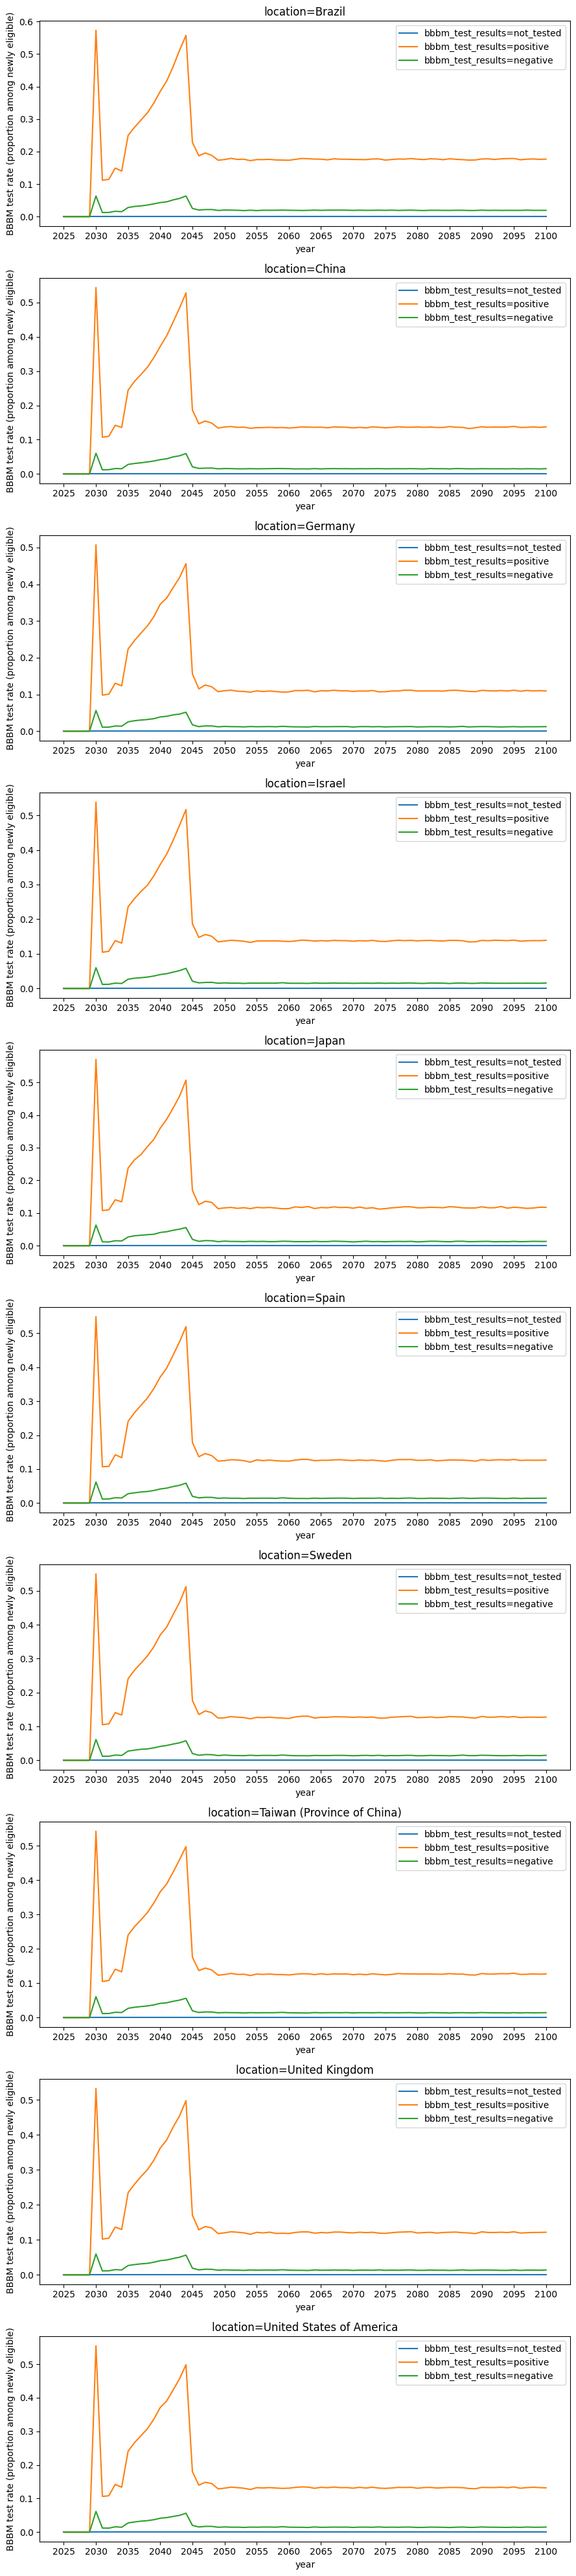

In [139]:
fig = plot_over_time_by_column_for_row_x_1(
    bbbm_test_rate.query("scenario=='bbbm_testing'"),
    'bbbm_test_results',
    'location',
    ylabel='BBBM test rate (proportion among newly eligible)',
    uncertainty=False,
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    ax.set_xticks(ax.get_xticks()[::5])
plt.show()


# Check whether `not_tested` is ever nonzero among BBBM test counts

No, it's always zero. That's good.

In [140]:
# Good -- when counting tested simulants, the results are never "not tested"
bbbm_test_counts.query("bbbm_test_results == 'not_tested'").value.unique()

array([0.])

In [141]:
# On the other hand, among eligible simulants, there are lots of people
# who haven't been tested
bbbm_test_eligibility_counts.query("bbbm_test_results == 'not_tested'").value.unique()

array([   0.,  649.,  333., ..., 3098., 2897., 2716.])

# Check that among eligible similants, there are no positive tests

Yes, all counts of positive tests among eligible simulants are zero.

In [142]:
# Good -- among eligible simulants, no one has tested positive.
bbbm_test_eligibility_counts.query("bbbm_test_results == 'positive'").value.unique()

array([0.])

In [143]:
# On the other hand, among tested simulants, there are positive test results
len(bbbm_test_counts.query("bbbm_test_results == 'positive'").value.unique())

881

# Check test sensitivity

Filter to testing scenario since there are no BBBM tests in baseline.

In [144]:
# TODO: Here would be a great place to use prefilter_query in the ratio
# function, once I implement it
bbbm_test_sensitivity = ops.ratio(
    bbbm_test_counts.query("scenario=='bbbm_testing'"),
    bbbm_test_counts.query("scenario=='bbbm_testing'"),
    strata=['event_year'],
    # Broadcast in numerator to get positive and negative test results
    numerator_broadcast='bbbm_test_results',
)
bbbm_test_sensitivity

,event_year,input_draw,scenario,location,bbbm_test_results,value,numerator_measure,denominator_measure,multiplier
0,2025,2,bbbm_testing,Brazil,not_tested,NaN,bbbm_test_counts,bbbm_test_counts,1
1,2025,2,bbbm_testing,Brazil,positive,NaN,bbbm_test_counts,bbbm_test_counts,1
2,2025,2,bbbm_testing,Brazil,negative,NaN,bbbm_test_counts,bbbm_test_counts,1
3,2025,2,bbbm_testing,China,not_tested,NaN,bbbm_test_counts,bbbm_test_counts,1
4,2025,2,bbbm_testing,China,positive,NaN,bbbm_test_counts,bbbm_test_counts,1
...,...,...,...,...,...,...,...,...,...
56995,2100,499,bbbm_testing,United Kingdom,positive,0.876404,bbbm_test_counts,bbbm_test_counts,1
56996,2100,499,bbbm_testing,United Kingdom,negative,0.123596,bbbm_test_counts,bbbm_test_counts,1
56997,2100,499,bbbm_testing,United States of America,not_tested,0.000000,bbbm_test_counts,bbbm_test_counts,1
56998,2100,499,bbbm_testing,United States of America,positive,0.877984,bbbm_test_counts,bbbm_test_counts,1


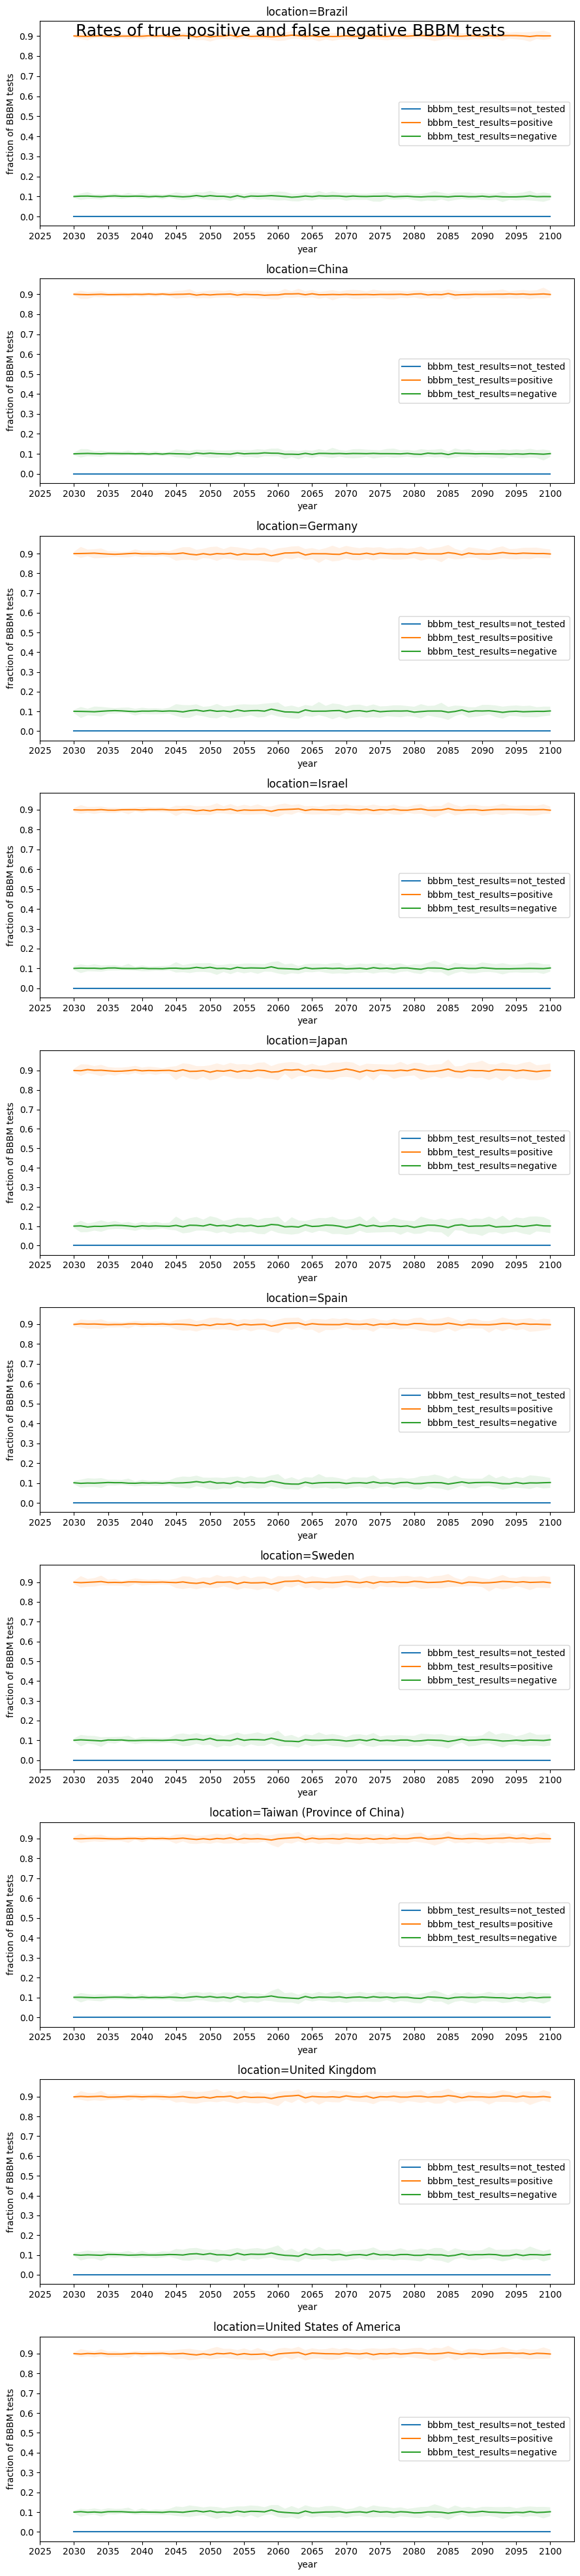

In [145]:
fig = plot_over_time_by_column_for_row_x_1(
    bbbm_test_sensitivity,#.query("bbbm_test_results != 'not_tested'"),
    'bbbm_test_results',
    'location',
    ylabel='fraction of BBBM tests',
    suptitle='Rates of true positive and false negative BBBM tests',
    uncertainty=True,
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    ax.set_xticks(ax.get_xticks()[::5])
    ax.set_yticks(np.arange(0,1, .1))
plt.show()


# Compute statistics on BBBM test sensitivity

In [146]:
bbbm_test_sensitivity_summary = ops.describe(
    bbbm_test_sensitivity.query("event_year >= '2030' and bbbm_test_results=='positive'"))
bbbm_test_sensitivity_summary

count  \
bbbm_test_results denominator_measure event_year location                   multiplier numerator_measure scenario              
positive          bbbm_test_counts    2030       Brazil                     1          bbbm_test_counts  bbbm_testing   25.0   
                                                 China                      1          bbbm_test_counts  bbbm_testing   25.0   
                                                 Germany                    1          bbbm_test_counts  bbbm_testing   25.0   
                                                 Israel                     1          bbbm_test_counts  bbbm_testing   25.0   
                                                 Japan                      1          bbbm_test_counts  bbbm_testing   25.0   
...                                                                                                                      ...   
                                      2100       Spain                      1          bbbm_test_counts  bbbm_testing   25.0   
                                                 Sweden                     1          bbbm_test_counts  bbbm_testing   25.0   
                                                 Taiwan (Province of China) 1          bbbm_test_counts  bbbm_testing   25.0   
                                                 United Kingdom             1          bbbm_test_counts  bbbm_testing   25.0   
                                                 United States of America   1          bbbm_test_counts  bbbm_testing   25.0   

                                                                                                                           mean  \
bbbm_test_results denominator_measure event_year location                   multiplier numerator_measure scenario                 
positive          bbbm_test_counts    2030       Brazil                     1          bbbm_test_counts  bbbm_testing  0.900304   
                                                 China                      1          bbbm_test_counts  bbbm_testing  0.900123   
                                                 Germany                    1          bbbm_test_counts  bbbm_testing  0.899902   
                                                 Israel                     1          bbbm_test_counts  bbbm_testing  0.899588   
                                                 Japan                      1          bbbm_test_counts  bbbm_testing  0.899811   
...                                                                                                                         ...   
                                      2100       Spain                      1          bbbm_test_counts  bbbm_testing  0.897569   
                                                 Sweden                     1          bbbm_test_counts  bbbm_testing  0.896797   
                                                 Taiwan (Province of China) 1          bbbm_test_counts  bbbm_testing  0.898775   
                                                 United Kingdom             1          bbbm_test_counts  bbbm_testing  0.897379   
                                                 United States of America   1          bbbm_test_counts  bbbm_testing  0.897960   

                                                                                                                            std  \
bbbm_test_results denominator_measure event_year location                   multiplier numerator_measure scenario                 
positive          bbbm_test_counts    2030       Brazil                     1          bbbm_test_counts  bbbm_testing  0.003997   
                                                 China                      1          bbbm_test_counts  bbbm_testing  0.003757   
                                                 Germany                    1          bbbm_test_counts  bbbm_testing  0.004358   
                                                 Israel                     1          bbbm_tes

In [147]:
bbbm_test_sensitivity_summary['mean'].describe()

count    710.000000
mean       0.899311
std        0.002782
min        0.888933
25%        0.897929
50%        0.899317
75%        0.900964
max        0.907496
Name: mean, dtype: float64

# Compute test result fractions among newly eligible simulants

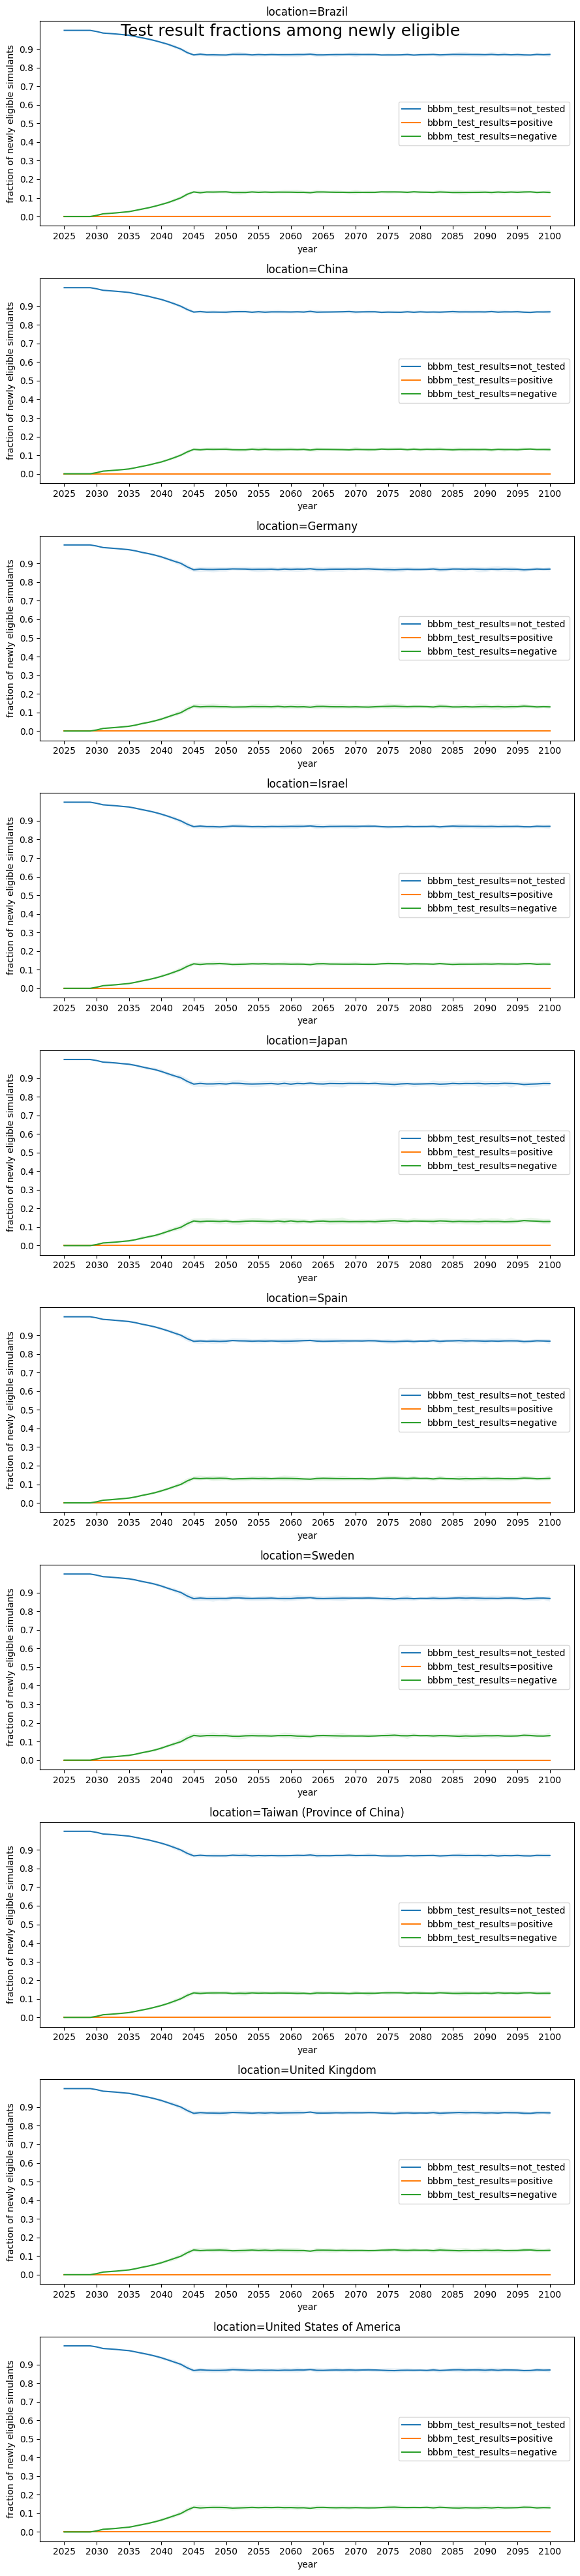

In [148]:
# TODO: Here would be a great place to use prefilter_query in the ratio
# function, once I implement it
bbbm_test_result_fractions_among_eligible = ops.ratio(
    bbbm_test_eligibility_counts.query("scenario=='bbbm_testing'"),
    bbbm_test_eligibility_counts.query("scenario=='bbbm_testing'"),
    strata=['event_year'],
    numerator_broadcast='bbbm_test_results',
)

fig = plot_over_time_by_column_for_row_x_1(
    bbbm_test_result_fractions_among_eligible,
    'bbbm_test_results',
    'location',
    ylabel='fraction of newly eligible simulants',
    suptitle='Test result fractions among newly eligible',
    uncertainty=True,
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    ax.set_xticks(ax.get_xticks()[::5])
    ax.set_yticks(np.arange(0,1, .1))
plt.show()

# Plot numerators and denominators of BBBM test rate

In [149]:
bbbm_test_rate_numerator = ops.stratify(bbbm_test_counts, 'event_year')
bbbm_test_rate_denominator = ops.stratify(bbbm_test_eligibility_counts, 'event_year')
bbbm_test_rate_num_and_denom = pd.concat(
    [numerator, denominator],
    keys=['tests', 'newly_eligible'],
    names=['count'],
).reset_index('count').reset_index(drop=True)
bbbm_test_rate_num_and_denom

,count,event_year,input_draw,scenario,location,value
0,tests,2025,356,baseline,Japan,0.0
1,tests,2025,356,baseline,Germany,0.0
2,tests,2025,356,baseline,Spain,0.0
3,tests,2025,356,baseline,Sweden,0.0
4,tests,2025,356,baseline,United Kingdom,0.0
...,...,...,...,...,...,...
75995,newly_eligible,2100,265,bbbm_testing,United States of America,2641.0
75996,newly_eligible,2100,265,bbbm_testing,Israel,3083.0
75997,newly_eligible,2100,265,bbbm_testing,Taiwan (Province of China),3495.0
75998,newly_eligible,2100,265,bbbm_testing,Brazil,3846.0


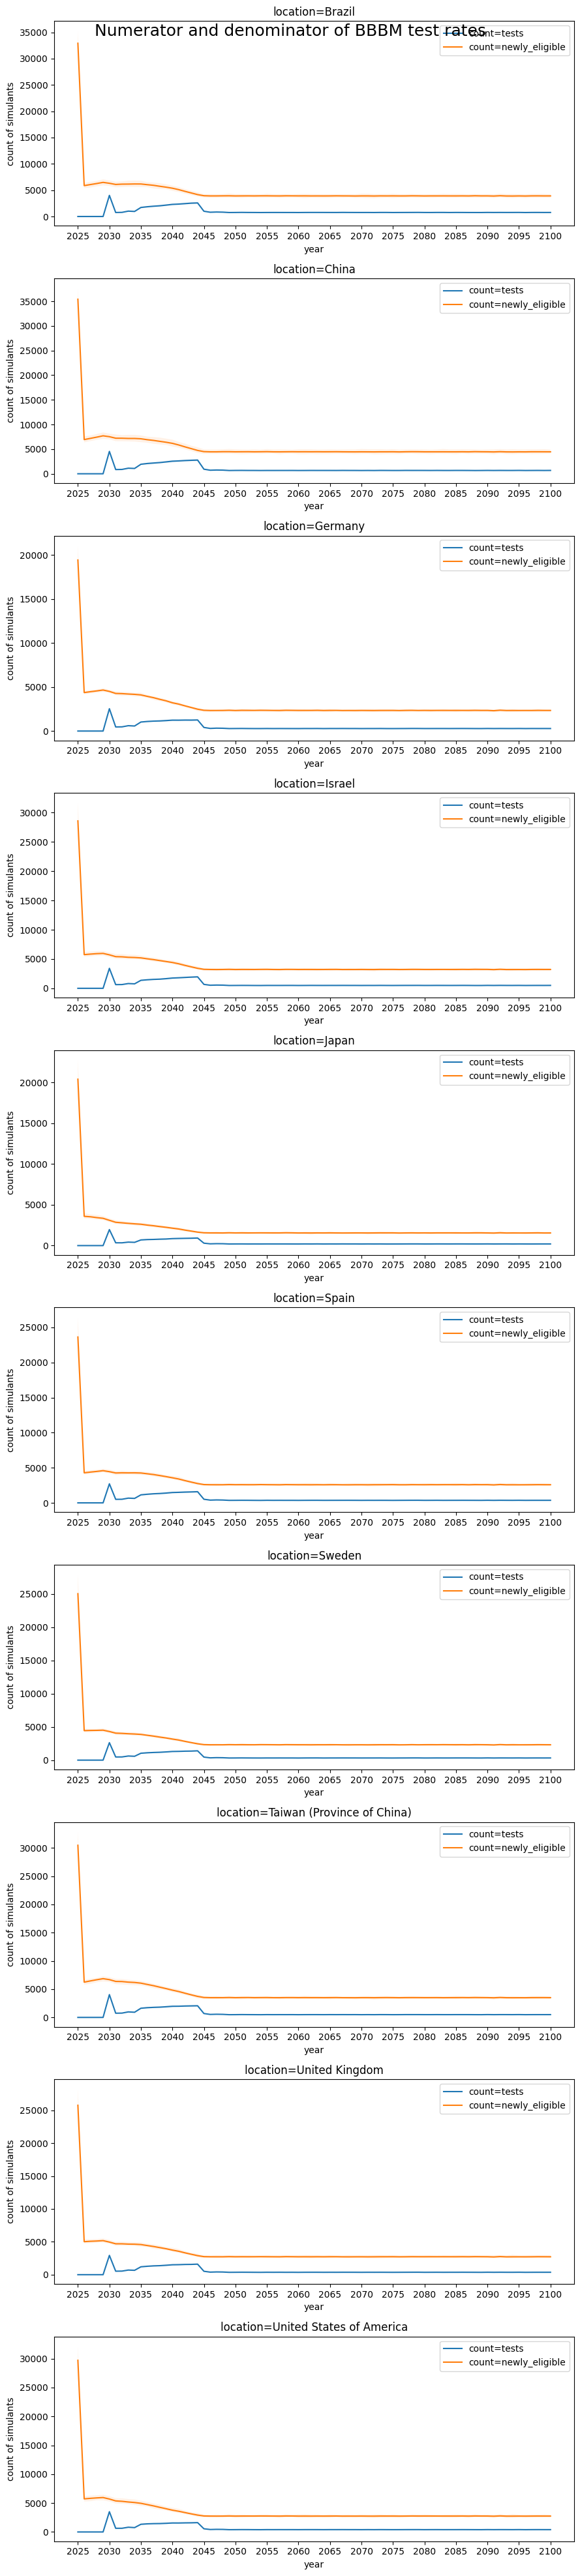

In [150]:
fig = plot_over_time_by_column_for_row_x_1(
    bbbm_test_rate_num_and_denom.query("scenario=='bbbm_testing'"),
    'count',
    'location',
    ylabel='count of simulants',
    suptitle='Numerator and denominator of BBBM test rates',
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    ax.set_xticks(ax.get_xticks()[::5])
plt.show()